In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [2]:
import time
import operator
from collections import Counter
from xgboost import plot_tree

import xgboost as xgb
#import lightgbm as lgb
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier

import matplotlib.pyplot as plt
from contextlib import contextmanager
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name} done in {time.time() - start_time:.2f} s]')

In [3]:
train = pd.read_csv('data/complete_train.csv')
test = pd.read_csv('data/test.csv')
print(Counter(train['day']).keys())
print(Counter(test['day']).keys())

dict_keys([17, 18, 20, 21, 19, 22, 23, 24])
dict_keys([25, 24])


In [4]:
train.columns

Index(['instance_id', 'item_id', 'item_property_list', 'item_brand_id',
       'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'shop_id',
       'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level',
       'shop_score_service', 'shop_score_delivery', 'shop_score_description',
       'is_trade', 'datetime', 'day', 'hour', 'time', 'is_midnight',
       'is_morning', 'is_afternoon', 'is_night', 'item_category',
       'cate_precision', 'cate_recall', 'prop_precision', 'prop_recall'],
      dtype='object')

In [5]:
# sort data according to day and time
train = train.sort_values(by = ['day','time']).reset_index().iloc[:, 1:]
# convert hour to time slot
# is_midnight: 0, is_morning: 1, is_afternoon: 2, is_night: 3
def f(x):
    if x <= 7:
        return 0
    elif x > 7 and x <= 13:
        return 1
    elif x > 13 and x <= 19:
        return 2
    else:
        return 3
train['hour'] = train['hour'].apply(lambda x: f(x))
to_drop = ['is_morning','is_midnight','is_afternoon','is_night']
train= train.drop(to_drop, axis=1)

In [6]:
# delete some features
# check importance of features
exclude_features = ['instance_id','context_id', 'context_timestamp', 'is_trade','datetime', 'day', 'time','item_property_list']
df_train = train[(train['day'] >= 17) & (train['day'] <= 22)]
df_val = train[(train['day'] >= 23) & (train['day'] <= 24)]
y_train = df_train['is_trade']
x_train = df_train.drop(exclude_features, axis = 1)
y_val = df_val['is_trade']
x_val = df_val.drop(exclude_features, axis = 1)

In [7]:
# prepare for training
params = {'max_depth':9, # 3-10
          'eta':0.05, # 0.01-0.2 analogous to learning rate
          'subsample':0.8, #0.5-1 denote the fraction of observations to be randomly samples for each tree.
          'colsample_bytree':0.5, #0.5-1 denote the fraction of columns to be randomly samples for each tree.
          'min_child_weight':14,
          'lambda':0.5,
          
          'seed':123,
          'nthread':25,
          'eval_metric':'logloss', #rmse, logloss, auc
          'objective':'binary:logistic',
          'silent':1
          
          # handle imbalanced dataset
          #'scale_pos_weight':0.5
          # 'max_delta_step': 1
          }
num_boost_round = 192

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_val, y_val)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [8]:
with timer('Train XBOOST'):
    xgb_model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                    early_stopping_rounds=100, verbose_eval=50)

[0]	train-logloss:0.648122	eval-logloss:0.647766
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[50]	train-logloss:0.109618	eval-logloss:0.101383
[100]	train-logloss:0.087825	eval-logloss:0.080033
[150]	train-logloss:0.084913	eval-logloss:0.079128
[191]	train-logloss:0.083294	eval-logloss:0.079105
[Train XBOOST done in 310.51 s]


In [9]:
features = [x for x in x_train.columns]
importance = xgb_model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])

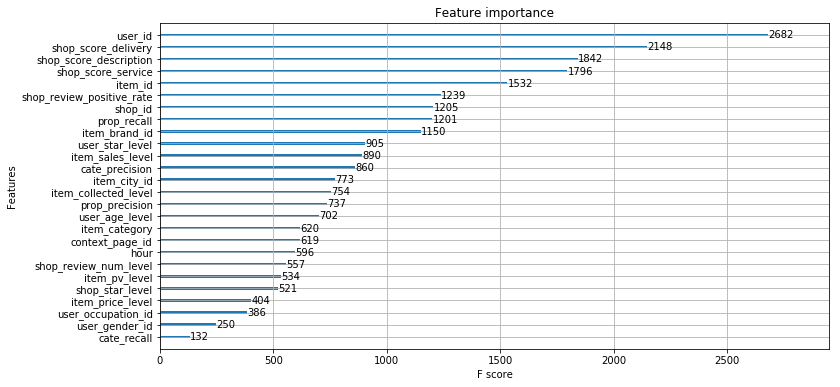

In [10]:
plt.rcParams['figure.figsize'] = 12, 6
xgb.plot_importance(xgb_model)
plt.show()

ImportError: You must install graphviz to plot tree

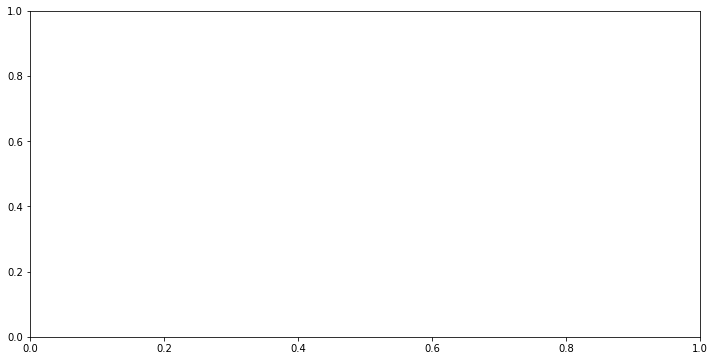

In [11]:
plot_tree(xgb_model)
plt.show()

In [11]:
xgb_model.best_score

0.079104

In [15]:
y_pred_val = xgb_model.predict(xgb.DMatrix(x_val))
xgb_val_logloss = log_loss(y_val, y_pred_val)

In [16]:
xgb_val_logloss

0.07910484583151141

In [17]:
# encoding with xgboost rule
x_train_leaves = xgboost.apply(x_train)
x_val_leaves = xgboost.apply(x_val)

NameError: name 'xgboost' is not defined

In [24]:
# LR based on original features
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_val = lr.predict_proba(x_val)[:,1]

In [25]:
lr_val_logloss = log_loss(y_val, y_pred_val)
print(lr_val_logloss)

0.08873298184524787


In [29]:
lr.coef_

array([[-1.14823047e-19, -1.21372437e-19, -2.05242279e-19,
        -9.87412692e-37, -1.01855076e-36, -1.29647245e-36,
        -1.95563482e-36, -1.07848023e-19, -1.51659290e-33,
        -1.19162060e-34, -3.59515360e-34, -3.56910053e-34,
        -4.75763772e-34, -1.14944351e-19, -1.88577002e-36,
        -1.19084302e-37, -5.95621895e-34, -1.16623236e-37,
        -1.16729024e-37, -1.17455455e-37, -8.33289335e-38,
        -1.36397901e-19, -5.63627557e-38, -1.08427449e-37,
        -4.88177220e-38, -4.43026662e-39]])

In [11]:
# convert all the numerical features to one-hot encoding
grd_enc = OneHotEncoder()
# Logistic Regression Classifier
grd_lm = LogisticRegression()

In [12]:
#['instance_id','context_id', 'context_timestamp', 'is_trade','datetime', 'day', 'time','item_property_list']
train = train.drop(exclude_features, axis = 1)

In [13]:
dall = xgb.DMatrix(train, feature_names = train.columns)
all_leafs = best_model.predict(dall, pred_leaf = True)
train_leafs = best_model.predict(dtrain, pred_leaf = True)
val_leafs = best_model.predict(dvalid, pred_leaf = True)

In [14]:
# use all features to form encoding rule
grd_enc.fit(all_leafs)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [1]:
oh_train = grd_enc.transform(train_leafs).toarray()
oh_val = grd_enc.transform(val_leafs).toarray()

NameError: name 'grd_enc' is not defined

$x_i$